In [1]:
%config Completer.use_jedi = False

In [2]:
DEBUG = False

In [3]:
import  sys
import os
if DEBUG:
    sys.path.remove('/home/ashesh.ashesh/code/Disentangle')
    sys.path.append("/home/ashesh.ashesh/debug/code/Disentangle")
else:
    sys.path.append("/home/ashesh.ashesh/code/Disentangle")

In [4]:
import random

import numpy as np
import torch
import pickle
import ml_collections
import glob
import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from disentangle.config_utils import load_config
from disentangle.analysis.lvae_utils import get_img_from_forward_output
from disentangle.analysis.plot_utils import clean_ax
from disentangle.core.data_type import DataType
from disentangle.core.data_split_type import DataSplitType

from disentangle.analysis.plot_utils import get_k_largest_indices,plot_imgs_from_idx
from disentangle.analysis.critic_notebook_utils import get_mmse_dict, get_label_separated_loss
from disentangle.core.psnr import PSNR, RangeInvariantPsnr

torch.multiprocessing.set_sharing_strategy('file_system')


def fix_seeds():
    torch.manual_seed(0)
    torch.cuda.manual_seed(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.deterministic = True

fix_seeds()

/home/ashesh.ashesh/miniconda3/envs/Disentangle/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# from disentangle.configs.customdata_lvae_config import get_config
# from disentangle.configs.twotiff_config import get_config
# data_dir = '/group/jug/damian/data_for_Ashesh/'
from disentangle.configs.microscopy_multi_channel_lvae_config import get_config
data_dir = '/group/jug/ashesh/data/microscopy/'

batch_size = 16
num_workers = 0
COMPUTE_LOSS = True

custom_image_size = None #512
use_deterministic_grid = None
threshold = None # 0.02
compute_kl_loss = False
evaluate_train = False # inspect training performance
val_repeat_factor = None
psnr_type = 'range_invariant' #'simple', 'range_invariant'

In [6]:
config = get_config()
# ckpt_dir = '/home/ashesh.ashesh/debug/training/disentangle/2208/D4-M3-S0-L0/8'
# config = config = load_config(ckpt_dir)

config = ml_collections.ConfigDict(config)
old_image_size = None
with config.unlocked():
#     config.data.multiscale_lowres_count = 3
    if 'logvar_lowerbound' not in config.model:
        config.model.logvar_lowerbound = None
    if 'train_aug_rotate' not in config.data:
        config.data.train_aug_rotate = False
    if 'multiscale_lowres_separate_branch' not in config.model:
        config.model.multiscale_lowres_separate_branch = False
    if 'multiscale_retain_spatial_dims' not in config.model:
        config.model.multiscale_retain_spatial_dims = False
    config.data.train_aug_rotate=False
    
    if 'randomized_channels' not in config.data:
        config.data.randomized_channels = False
        
    if 'predict_logvar' not in config.model:
        config.model.predict_logvar=None
    if config.data.data_type == DataType.OptiMEM100_014:
        if custom_image_size is not None:
            old_image_size = config.data.image_size
            config.data.image_size = custom_image_size
        if use_deterministic_grid is not None:
            config.data.deterministic_grid = use_deterministic_grid
        if threshold is not None:
            config.data.threshold = threshold
        if val_repeat_factor is not None:
            config.training.val_repeat_factor = val_repeat_factor
        config.model.mode_pred = not compute_kl_loss

config

data:
  background_quantile: 0.0
  channel_1: 2
  channel_2: 3
  clip_background_noise_to_zero: false
  clip_percentile: 0.995
  data_type: 3
  deterministic_grid: false
  image_size: 256
  input_is_sum: false
  multiscale_lowres_count: null
  normalized_input: true
  padding_mode: reflect
  padding_value: null
  randomized_channels: false
  sampler_type: 0
  skip_normalization_using_mean: false
  target_separate_normalization: false
  train_aug_rotate: false
  use_one_mu_std: true
datadir: ''
exptname: ''
git:
  branch: ''
  changedFiles: []
  latest_commit: ''
  untracked_files: []
hostname: ''
loss:
  free_bits: 0.0
  kl_annealing: false
  kl_annealtime: 10
  kl_min: 1.0e-07
  kl_start: -1
  kl_weight: 1
  loss_type: 0
model:
  analytical_kl: false
  decoder:
    batchnorm: true
    blocks_per_layer: 1
    conv2d_bias: true
    dropout: 0.1
    multiscale_retain_spatial_dims: false
    n_filters: 64
    res_block_kernel: 3
    res_block_skip_padding: false
  enable_noise_model: fals

In [7]:
# config.data.padding_value

In [8]:
# train_dset, val_dset = create_dataset(config, data_dir,skip_train_dataset=False)
from disentangle.data_loader.autoregressive_dloader import AutoRegressiveDloader

padding_kwargs = {
    'mode':config.data.get('padding_mode','constant'),
}
if padding_kwargs['mode'] == 'constant':
    padding_kwargs['constant_values'] = config.data.get('padding_value',237)

dloader_kwargs = {}
# data_class = get_overlapping_dset(MultiChDeterministicTiffDloader)
if config.data.data_type == DataType.OptiMEM100_014:
    datapath = os.path.join(data_dir, 'OptiMEM100x014.tif')
elif config.data.data_type in [DataType.CustomSinosoid, DataType.SeparateTiffData]:
    datapath = data_dir
    
normalized_input = config.data.normalized_input
use_one_mu_std = config.data.use_one_mu_std
train_aug_rotate = config.data.train_aug_rotate
enable_random_cropping = config.data.deterministic_grid is False

train_dset = AutoRegressiveDloader(
                config.data,
                datapath,
                datasplit_type=DataSplitType.Train,
                val_fraction=config.training.val_fraction,
                test_fraction=config.training.test_fraction,
                normalized_input=normalized_input,
                use_one_mu_std=use_one_mu_std,
                enable_rotation_aug=train_aug_rotate,
                enable_random_cropping=enable_random_cropping,
                
                **dloader_kwargs)

max_val = train_dset.get_max_val()
val_dset = AutoRegressiveDloader(
                config.data,
                datapath,
                datasplit_type=DataSplitType.Test,
                val_fraction=config.training.val_fraction,
                test_fraction=config.training.test_fraction,
                normalized_input=normalized_input,
                use_one_mu_std=use_one_mu_std,
                enable_rotation_aug=False,  # No rotation aug on validation
                enable_random_cropping=False,
                max_val=max_val,
                # No random cropping on validation. Validation is evaluated on determistic grids
                
                **dloader_kwargs
                
            )

# For normalizing, we should be using the training data's mean and std.
mean_val, std_val = train_dset.compute_mean_std()
train_dset.set_mean_std(mean_val, std_val)
val_dset.set_mean_std(mean_val, std_val)


if evaluate_train:
    val_dset = train_dset
data_mean, data_std = train_dset.get_mean_std()


Loading /group/jug/ashesh/data/microscopy/OptiMEM100x014.tif with Channels 2,3,datasplit mode:Train
[AutoRegressiveDloader] Sz:256 Train:1 N:49 NumPatchPerN:100 NormInp:True SingleNorm:True Rot:False RandCrop:True Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0
Loading /group/jug/ashesh/data/microscopy/OptiMEM100x014.tif with Channels 2,3,datasplit mode:Test
[AutoRegressiveDloader] Sz:256 Train:0 N:6 NumPatchPerN:100 NormInp:True SingleNorm:True Rot:False RandCrop:False Q:0.995 SummedInput:False ReplaceWithRandSample:False BckQ:0.0


In [9]:
val_dset.idx_manager._data_shape

(6, 2720, 2720, 2)

In [10]:
len(val_dset)

600

In [11]:
val_dset[10583]

(array([], shape=(2, 0, 256), dtype=float32),
 array([], shape=(2, 0, 256), dtype=float32))

448


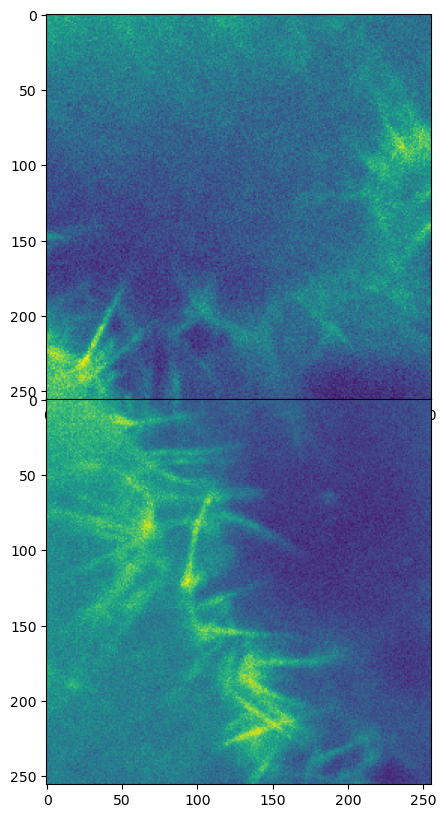

In [30]:
idx = np.random.randint(len(val_dset))
print(idx)
inp, tar = val_dset[idx]
_,ax = plt.subplots(figsize=(5,10),nrows=2)
ax[1].imshow(inp[0])
ax[0].imshow(inp[1])
plt.subplots_adjust(wspace=0, hspace=0)
